In [1]:
from models import BlackScholes, MonteCarlo, Heston, Dupire, SABR
from calibration import Calibration
from visualization.graphics import Graphics
import datetime as dt
import pandas as pd
import numpy as np

In [2]:
ticker = '^SPX'
end  = dt.datetime.now()
start = end - dt.timedelta(days=180) # 180 days is common when you consider the volatility constant
calibration = Calibration(ticker, start, end)


1 Failed download:
['^SPX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')



1 Failed download:
['^SPX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


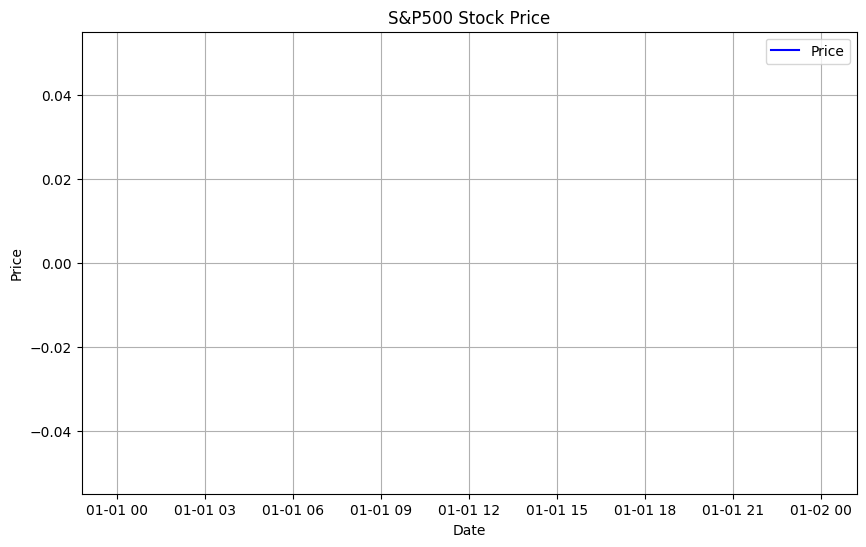

In [3]:
spx_historical_prices = calibration.get_historical_prices_df()
# Initialize Graphics class
graphics = Graphics()
# Plot stock chart
graphics.plot_stock_chart(spx_historical_prices, 'S&P500')

In [4]:
S0 = calibration.get_latest_price()
S0 # Current price of the underlying asset

YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

In [ ]:
K = S0 # Strike price
T = 1  # Time to maturity (1 year)

In [ ]:
hist_mu = calibration.get_historical_mu()
hist_sigma = calibration.get_historical_sigma()
r = calibration.get_risk_free_rate()
print(f"Historical mu: {hist_mu}, Historical sigma: {hist_sigma}, Risk free rate: {r}")

Historical mu: 0.0084, Historical sigma: 0.1269, Risk free rate: 0.0422


---

# Monte Carlo

In [28]:
confidence_level = 0.99  # Confidence level
n_simul = 50000  # Number of simulations

# Example usage of MonteCarlo
mc = MonteCarlo(S_0=S0, K=K, T=T, mu=hist_mu, sigma=hist_sigma, option_type="C")
option_price_mc = mc.get_option_price()
print(f"Monte Carlo Option Price: {option_price_mc}")

Monte Carlo Option Price: 341.61986277624993


---

# Black-Scholes-Merton

In [29]:
# Example usage of BlackScholes
bs = BlackScholes(r=r, S=S0, K=K, T=T, sigma=hist_sigma, option_type="C")
option_price = bs.calculate_option_price()
print(f"Black-Scholes Option Price: {option_price}")

Black-Scholes Option Price: 442.70527408957423


---


# Heston

In [62]:
# Load the calibrated parameters from the CSV file
params_df = pd.read_csv("data/heston_calibrated_parameters.csv")

# Extract the parameters
v0 = params_df["v0"].iloc[0]
kappa = params_df["kappa"].iloc[0]
theta = params_df["theta"].iloc[0]
sigma_heston = params_df["sigma"].iloc[0]
rho_heston = params_df["rho"].iloc[0]
lambd = params_df["lambd"].iloc[0]
#calibration_date = params_df["calibration_date"].iloc[0]

In [63]:
v0, kappa, theta, sigma_heston, rho_heston, lambd

(0.2133902971355713, 4.574961397035306, 0.001, 2.0, -0.254361338282851, 1.0)

In [32]:
heston_model = Heston(S0=S0, K=K, r=r, T=T, option_type="C",
                      v0=v0, kappa=kappa, theta=theta, sigma=sigma_heston, rho=rho_heston, lambd=lambd)
heston_option_price = heston_model.calculate_option_price()
print(f"Heston Option Price: {heston_option_price}")

Heston Option Price: 596.3048332047154


---
# Dupire

---
# SABR

In [66]:
# Load the calibrated parameters from the CSV file
sabr_params = pd.read_csv("data/sabr_calibrated_parameters.csv")

# Extract the parameters
alpha = sabr_params["alpha"].iloc[0]
beta = sabr_params["beta"].iloc[0]
rho_sabr = sabr_params["rho"].iloc[0]
nu = sabr_params["nu"].iloc[0]
#calibration_date = params_df["calibration_date"].iloc[0]

In [67]:
alpha, beta, rho_sabr, nu

(5.365552950303491, 0.5754187709854673, 0.1087478515403324, 0.058750268515032)

In [37]:
sabr_model = SABR(S0=S0, K=K, r=r, T=T, alpha=alpha, beta=beta, rho=rho_sabr, nu=nu, option_type="C")
sabr_option_price = sabr_model.calculate_option_price()
print(f"SABR Option Price: {sabr_option_price}")

SABR Option Price: 453.3120486975813


---

In [74]:
import yfinance as yf
import pandas as pd

# Fetch option data for a specific ticker (e.g., AAPL)
ticker = "AAPL"
stock = yf.Ticker(ticker)
option_dates = stock.options  # Available expiration dates

In [75]:
option_date = option_dates[0]

In [76]:
# Fetch call options for the first expiration date
option_chain = stock.option_chain(option_date)
market_prices = option_chain.calls['lastPrice'].values
strikes = option_chain.calls['strike'].values
maturities = [option_date] * len(strikes)  # Same maturity for all strikes

In [77]:
# Initialize models with the same parameters
calibration = Calibration(ticker, start, end)

In [78]:
S0 = calibration.get_latest_price()
S0

231.07

In [79]:
r = calibration.get_risk_free_rate()
r

0.0422

In [80]:
T = round((pd.to_datetime(option_date) - pd.Timestamp.today()).days / 365,1)  # Time to maturity in years
T

0.0

In [81]:
bs_prices = []
for K in strikes:
    bs = BlackScholes(r=r, S=S0, K=K, T=T,sigma=hist_sigma, option_type='C')
    bs_prices.append(bs.calculate_option_price())

/Users/jonathanlevel/Desktop/Scolaire/Supérieur/TSP/3A/PFE/Option_Pricing/models/black_scholes.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(self.S / self.K) + (self.r + self.sigma**2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))


In [82]:
heston_prices = []
for K in strikes:
    heston = Heston(S0=S0, K=K, r=r, T=T, option_type="C",
                      v0=v0, kappa=kappa, theta=theta, sigma=sigma_heston, rho=rho_heston, lambd=lambd)
    heston_prices.append(heston.calculate_option_price())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


In [83]:
sabr_prices = []
for K in strikes:
    sabr = SABR(S0=S0, K=K, r=r, T=T, alpha=alpha, beta=beta, rho=rho_sabr, nu=nu, option_type="C")
    sabr_prices.append(sabr.calculate_option_price())

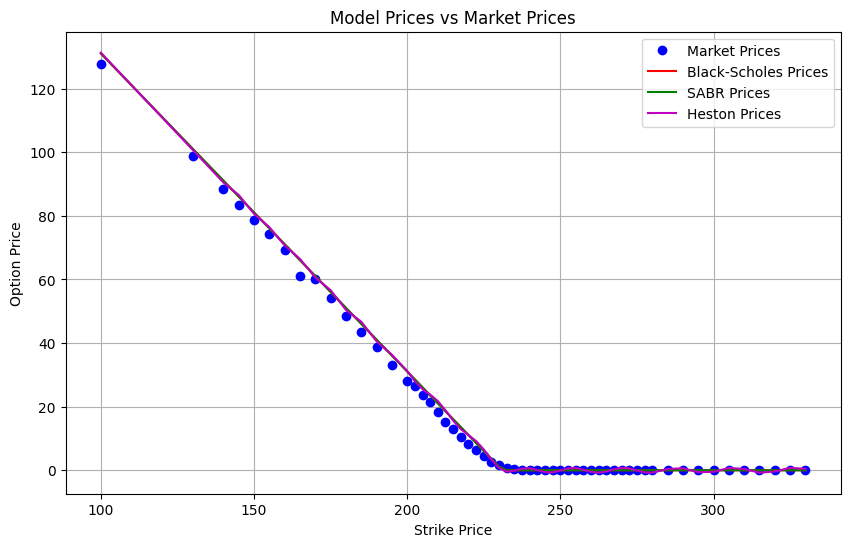

In [84]:
import matplotlib.pyplot as plt

# Plot market prices vs model prices
plt.figure(figsize=(10, 6))
plt.plot(strikes, market_prices, 'bo', label='Market Prices')
plt.plot(strikes, bs_prices, 'r-', label='Black-Scholes Prices')
plt.plot(strikes, sabr_prices, 'g-', label='SABR Prices')
plt.plot(strikes, heston_prices, 'm-', label='Heston Prices')
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.title("Model Prices vs Market Prices")
plt.legend()
plt.grid(True)
plt.show()

In [85]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compute RMSE for each model
bs_rmse = np.sqrt(mean_squared_error(market_prices, bs_prices))
sabr_rmse = np.sqrt(mean_squared_error(market_prices, sabr_prices))
heston_rmse = np.sqrt(mean_squared_error(market_prices, heston_prices))

print("Black-Scholes RMSE:", bs_rmse)
print("SABR RMSE:", sabr_rmse)
print("Heston RMSE:", heston_rmse)

Black-Scholes RMSE: 1.7570714271195644
SABR RMSE: 1.7570714271195644
Heston RMSE: 1.8411427387616928


/Users/jonathanlevel/Desktop/Scolaire/Supérieur/TSP/3A/PFE/Option_Pricing/models/black_scholes.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(self.S / self.K) + (self.r + self.sigma**2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


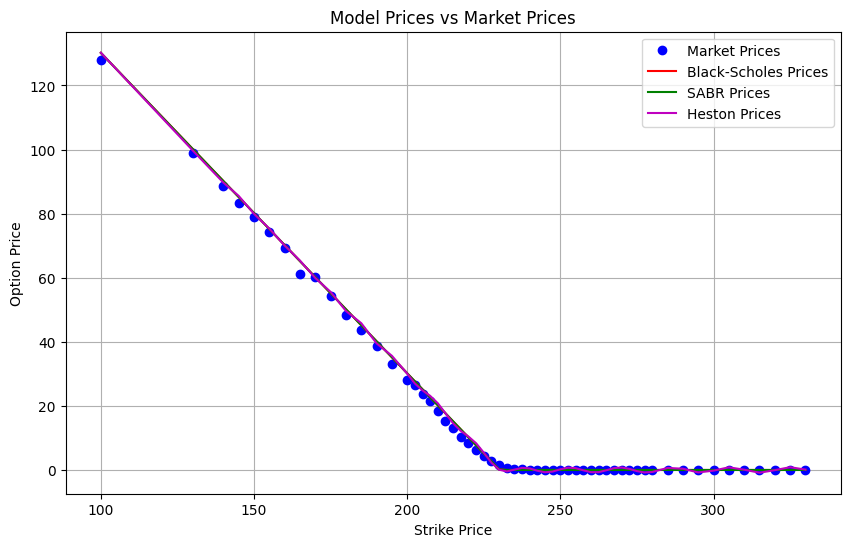

Black-Scholes RMSE: 1.2082790460642365
SABR RMSE: 1.2082790460642365
Heston RMSE: 1.3043094580160384


In [86]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from models.black_scholes import BlackScholes
from models.heston import Heston
from models.sabr import SABR
from calibration.calibration import Calibration

def analyze_option_prices(ticker, n):
    """
    Analyze option prices for a given ticker and expiration date index.

    :param ticker: The ticker symbol of the asset (e.g., "AAPL").
    :param n: The index of the expiration date to use from the available option dates.
    """
    # Fetch option data for the specified ticker
    stock = yf.Ticker(ticker)
    option_dates = stock.options  # Available expiration dates
    option_date = option_dates[n]

    # Fetch call options for the specified expiration date
    option_chain = stock.option_chain(option_date)
    market_prices = option_chain.calls['lastPrice'].values
    strikes = option_chain.calls['strike'].values
    maturities = [option_date] * len(strikes)  # Same maturity for all strikes

    # Initialize models with the same parameters
    calibration = Calibration(ticker, start='2022-01-01', end='2023-01-01')
    S0 = calibration.get_latest_price()
    r = calibration.get_risk_free_rate()
    T = round((pd.to_datetime(option_date) - pd.Timestamp.today()).days / 365, 1)  # Time to maturity in years

    # Calculate historical volatility (example value, replace with actual calculation)
    hist_sigma = 0.2

    # Calculate model prices
    bs_prices = [BlackScholes(r=r, S=S0, K=K, T=T, sigma=hist_sigma, option_type='C').calculate_option_price() for K in strikes]
    heston_prices = [Heston(S0=S0, K=K, r=r, T=T, option_type="C",
                            v0=0.04, kappa=2.0, theta=0.04, sigma=0.5, rho=-0.7, lambd=0.0).calculate_option_price() for K in strikes]
    sabr_prices = [SABR(S0=S0, K=K, r=r, T=T, alpha=0.04, beta=0.5, rho=-0.4, nu=0.3, option_type="C").calculate_option_price() for K in strikes]

    # Plot market prices vs model prices
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, market_prices, 'bo', label='Market Prices')
    plt.plot(strikes, bs_prices, 'r-', label='Black-Scholes Prices')
    plt.plot(strikes, sabr_prices, 'g-', label='SABR Prices')
    plt.plot(strikes, heston_prices, 'm-', label='Heston Prices')
    plt.xlabel("Strike Price")
    plt.ylabel("Option Price")
    plt.title("Model Prices vs Market Prices")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compute RMSE for each model
    bs_rmse = np.sqrt(mean_squared_error(market_prices, bs_prices))
    sabr_rmse = np.sqrt(mean_squared_error(market_prices, sabr_prices))
    heston_rmse = np.sqrt(mean_squared_error(market_prices, heston_prices))

    print("Black-Scholes RMSE:", bs_rmse)
    print("Heston RMSE:", heston_rmse)
    print("SABR RMSE:", sabr_rmse)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


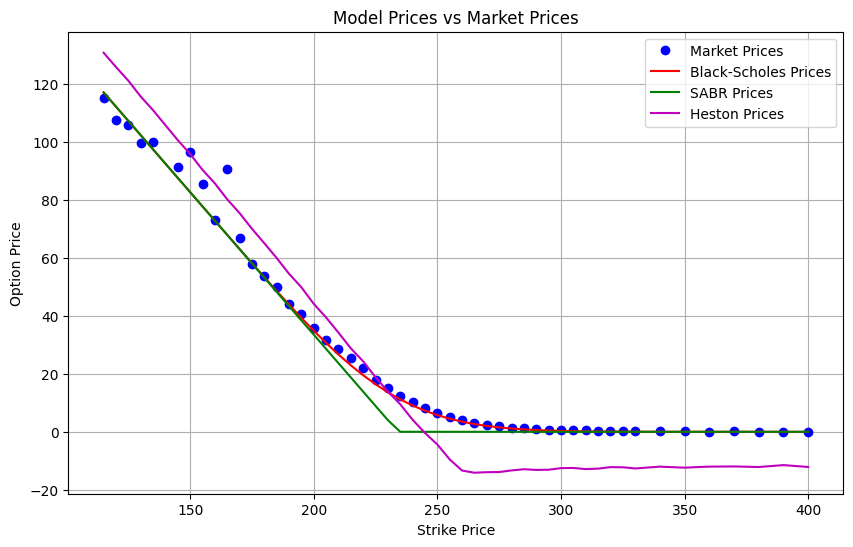

Black-Scholes RMSE: 4.153688359014849
SABR RMSE: 5.693495558013547
Heston RMSE: 11.80110665001699


In [87]:
# Example usage
analyze_option_prices("AAPL", 10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


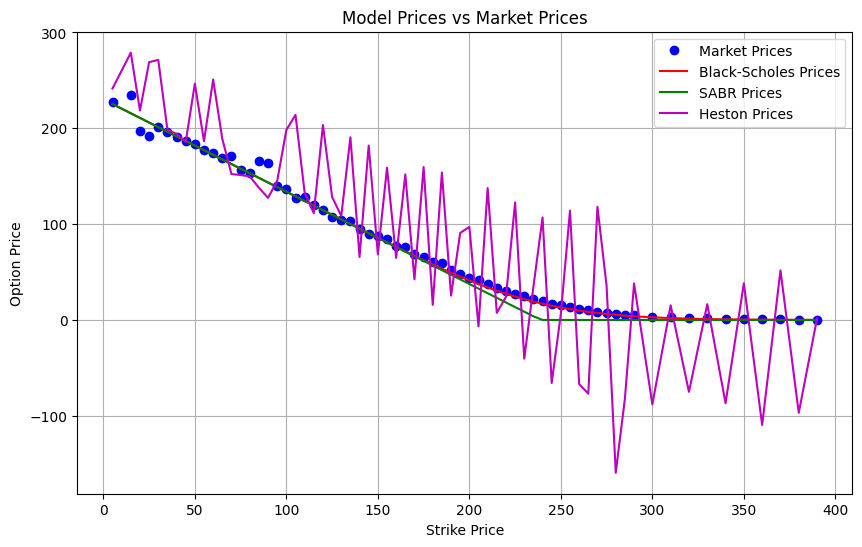

Black-Scholes RMSE: 5.196685757373828
SABR RMSE: 8.249011932220318
Heston RMSE: 62.587317912378815


In [89]:
analyze_option_prices("AAPL", 15)

/Users/jonathanlevel/Desktop/Scolaire/Supérieur/TSP/3A/PFE/Option_Pricing/models/black_scholes.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(self.S / self.K) + (self.r + self.sigma**2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
/Users/jonathanlevel/Desktop/Scolaire/Supérieur/TSP/3A/PFE/Option_Pricing/models/black_scholes.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(self.S / self.K) + (self.r + self.sigma**2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  ret

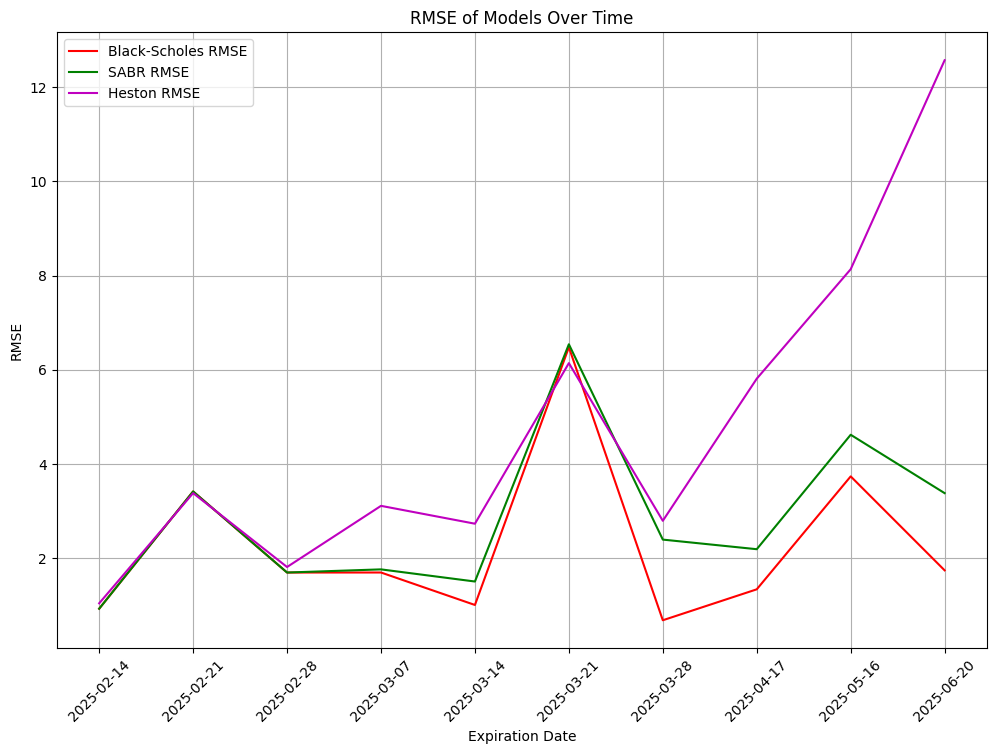

In [91]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from models.black_scholes import BlackScholes
from models.heston import Heston
from models.sabr import SABR
from calibration.calibration import Calibration

def analyze_option_prices_over_time(ticker):
    """
    Analyze option prices for a given ticker over all available expiration dates.

    :param ticker: The ticker symbol of the asset (e.g., "AAPL").
    """
    # Fetch option data for the specified ticker
    stock = yf.Ticker(ticker)
    option_dates = stock.options  # Available expiration dates

    # Initialize lists to store RMSE values for each model
    bs_rmse_list = []
    sabr_rmse_list = []
    heston_rmse_list = []
    dates_list = []

    # Loop through each expiration date
    for option_date in option_dates[:10]:
        # Fetch call options for the current expiration date
        option_chain = stock.option_chain(option_date)
        market_prices = option_chain.calls['lastPrice'].values
        strikes = option_chain.calls['strike'].values

        # Initialize models with the same parameters
        calibration = Calibration(ticker, start='2022-01-01', end='2023-01-01')
        S0 = calibration.get_latest_price()
        r = calibration.get_risk_free_rate()
        T = round((pd.to_datetime(option_date) - pd.Timestamp.today()).days / 365, 1)  # Time to maturity in years

        # Calculate historical volatility (example value, replace with actual calculation)
        hist_sigma = 0.2

        # Calculate model prices
        bs_prices = [BlackScholes(r=r, S=S0, K=K, T=T, sigma=hist_sigma, option_type='C').calculate_option_price() for K in strikes]
        heston_prices = [Heston(S0=S0, K=K, r=r, T=T, option_type="C",
                                 v0=0.04, kappa=2.0, theta=0.04, sigma=0.5, rho=-0.7, lambd=0.0).calculate_option_price() for K in strikes]
        sabr_prices = [SABR(S0=S0, K=K, r=r, T=T, alpha=0.04, beta=0.5, rho=-0.4, nu=0.3, option_type="C").calculate_option_price() for K in strikes]

        # Compute RMSE for each model
        bs_rmse = np.sqrt(mean_squared_error(market_prices, bs_prices))
        sabr_rmse = np.sqrt(mean_squared_error(market_prices, sabr_prices))
        heston_rmse = np.sqrt(mean_squared_error(market_prices, heston_prices))

        # Store RMSE values and dates
        bs_rmse_list.append(bs_rmse)
        sabr_rmse_list.append(sabr_rmse)
        heston_rmse_list.append(heston_rmse)
        dates_list.append(option_date)

    # Plot RMSE over time
    plt.figure(figsize=(12, 8))
    plt.plot(dates_list, bs_rmse_list, 'r-', label='Black-Scholes RMSE')
    plt.plot(dates_list, sabr_rmse_list, 'g-', label='SABR RMSE')
    plt.plot(dates_list, heston_rmse_list, 'm-', label='Heston RMSE')
    plt.xlabel("Expiration Date")
    plt.ylabel("RMSE")
    plt.title("RMSE of Models Over Time")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Example usage
analyze_option_prices_over_time("AAPL")


/Users/jonathanlevel/Desktop/Scolaire/Supérieur/TSP/3A/PFE/Option_Pricing/models/black_scholes.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(self.S / self.K) + (self.r + self.sigma**2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
/Users/jonathanlevel/Desktop/Scolaire/Supérieur/TSP/3A/PFE/Option_Pricing/models/black_scholes.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(self.S / self.K) + (self.r + self.sigma**2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  ret

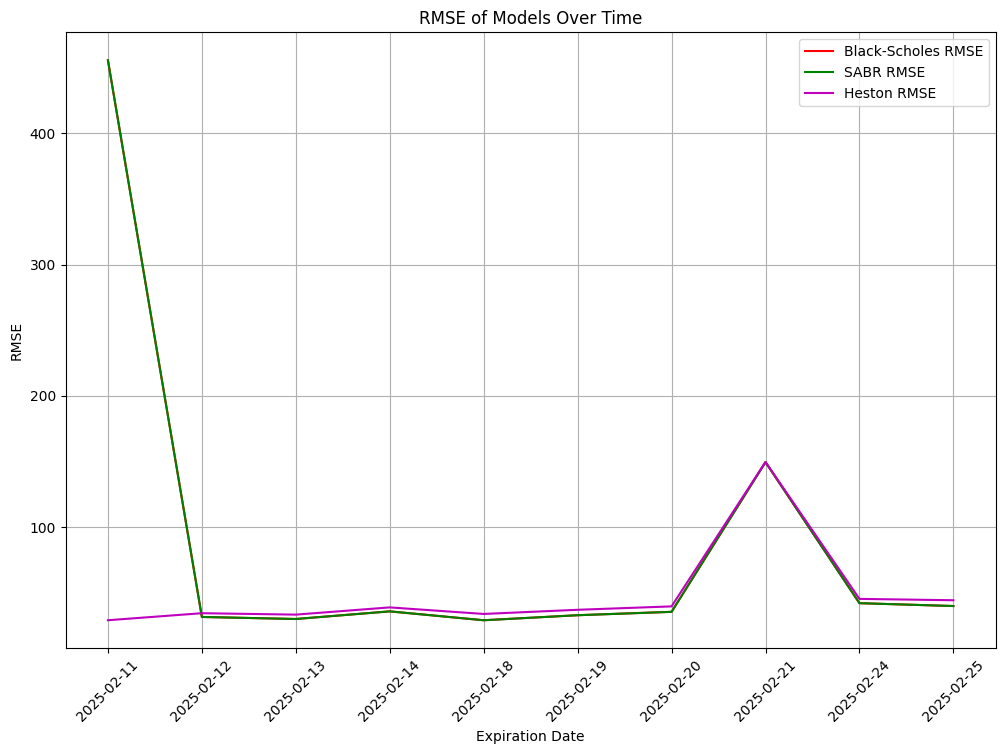

In [92]:
analyze_option_prices_over_time("^SPX")

/Users/jonathanlevel/Desktop/Scolaire/Supérieur/TSP/3A/PFE/Option_Pricing/models/black_scholes.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(self.S / self.K) + (self.r + self.sigma**2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
/Users/jonathanlevel/Desktop/Scolaire/Supérieur/TSP/3A/PFE/Option_Pricing/models/black_scholes.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(self.S / self.K) + (self.r + self.sigma**2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  ret

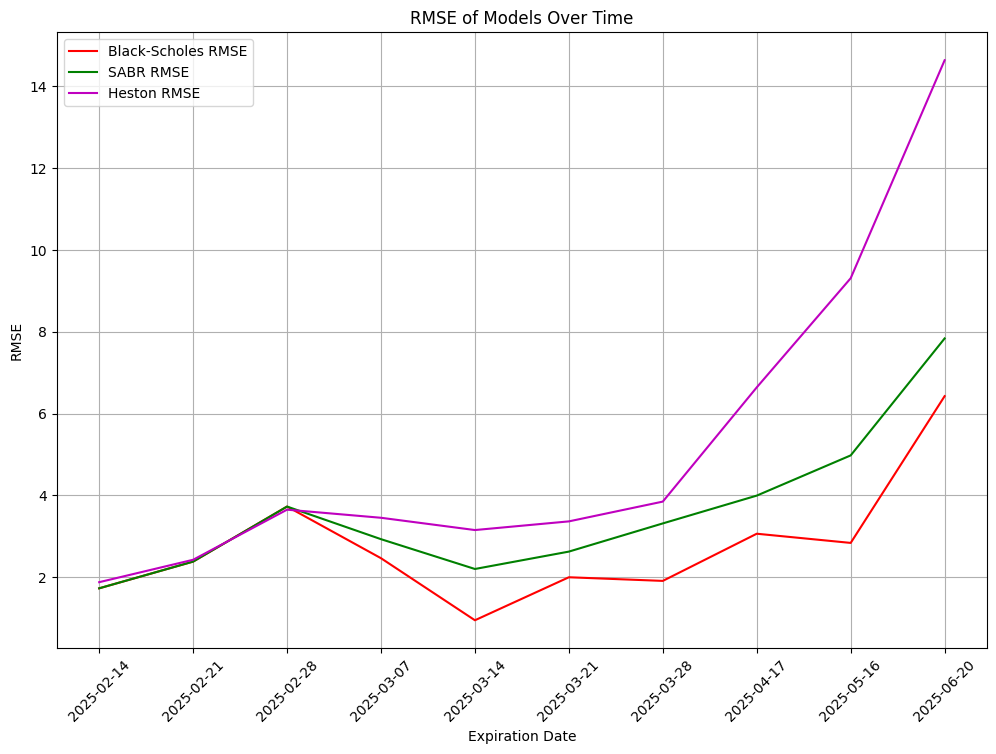

In [93]:
analyze_option_prices_over_time("AMZN")